In [20]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [21]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [22]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
!ls /content/gdrive/MyDrive

 1614671043843.gdoc
 31228
 31228_Arunima_Garg_Documents.pdf
 31228_Arunima_Garg.pdf
 31228_Arunima_Internship_Report.docx
 41148_LP3_Assignments
 41245_Maitreyee_NLP_A3.ipynb
 6.cpp.gdoc
'ACM group.jpeg'
 Arunima_Garg_Aadhar_Card.pdf
'Arunima Garg Internship Letter (1).pdf'
'Arunima Garg Internship Letter (2).pdf'
'Arunima Garg Internship Letter (3).pdf'
'Arunima Garg Internship Letter.pdf'
'Arunima Garg Profile_41228.pdf'
'Arunima Garg Profile.pdf'
'Arunima_Garg_resume (1).pdf'
'ArunimaGarg_Resume (1).pdf'
'Arunima_Garg_resume (2).pdf'
'ArunimaGarg_Resume (2).pdf'
'Arunima_Garg_resume (3).pdf'
'ArunimaGarg_Resume (3).pdf'
 Arunima_Garg_resume_final.pdf
 Arunima_Garg_resume.pdf
 ArunimaGarg_Resume.pdf
 ArunimaGarg.zip
'Arunima Photo.jpg'
'Arunima Web Developor.pdf'
 Australia.gslides
 Be_8
 binary_tree.cpp
 C2K20106556_ArunimaGarg_Documents.pdf
'C2K20106556_ArunimaGarg_Resume (1).pdf'
 C2K20106556_ArunimaGarg_resume.pdf
 C2K20106556_ArunimaGarg_Resume.pdf
'CIS-ITSM Certification'
'Cla

In [24]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/content/gdrive/MyDrive/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y


In [25]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os, glob

size = 128
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),   # random crop & resize
    transforms.RandomHorizontalFlip(),                      # flip 50% of the time
    transforms.RandomRotation(15),                          # rotate between -15° and +15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# ✅ Test data (no augmentation, only resize)
test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])

# -------------------
# Datasets & Loaders
# -------------------
trainset = Hotdog_NotHotdog(train=True, transform=train_transform, data_path='/content/gdrive/MyDrive/hotdog_nothotdog')
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=3)

testset = Hotdog_NotHotdog(train=False, transform=test_transform, data_path='/content/gdrive/MyDrive/hotdog_nothotdog')
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=3)

In [26]:
# images, labels = next(iter(train_loader))
# plt.figure(figsize=(20,10))

# for i in range(21):
#     plt.subplot(5,7,i+1)
#     plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
#     plt.title(['hotdog', 'not hotdog'][labels[i].item()])
#     plt.axis('off')


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------
# Model definition
# -----------------
class HotdogCNN(nn.Module):
    def __init__(self):
        super(HotdogCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.6)   # increased dropout
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling

        # Fully connected layers
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.gap(x)                # GAP reduces to (B, 256, 1, 1)
        x = torch.flatten(x, 1)        # flatten to (B, 256)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x




In [39]:
# -----------------
# Training setup
# -----------------
model = HotdogCNN().to(device)

# ✅ Label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-4
)

# ✅ Use adaptive LR scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

num_epochs = 30
patience = 5   # early stopping patience
best_loss = float("inf")
patience_counter = 0

In [40]:


# -----------------
for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # ---- Evaluation ----
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total

    # ---- Learning rate update ----
    scheduler.step(test_loss)

    # ---- Print stats ----
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")



Epoch [1/30] Train Loss: 0.6429, Train Acc: 66.24% | Test Loss: 0.8967, Test Acc: 48.07%
Epoch [2/30] Train Loss: 0.5832, Train Acc: 73.03% | Test Loss: 0.6240, Test Acc: 70.57%
Epoch [3/30] Train Loss: 0.5375, Train Acc: 76.65% | Test Loss: 0.5986, Test Acc: 73.52%
Epoch [4/30] Train Loss: 0.5145, Train Acc: 78.70% | Test Loss: 0.5702, Test Acc: 72.56%
Epoch [5/30] Train Loss: 0.5163, Train Acc: 79.09% | Test Loss: 0.5331, Test Acc: 75.40%
Epoch [6/30] Train Loss: 0.5130, Train Acc: 79.63% | Test Loss: 0.5039, Test Acc: 78.41%
Epoch [7/30] Train Loss: 0.4868, Train Acc: 81.68% | Test Loss: 0.5129, Test Acc: 77.44%
Epoch [8/30] Train Loss: 0.4808, Train Acc: 82.41% | Test Loss: 0.4908, Test Acc: 79.86%
Epoch [9/30] Train Loss: 0.4663, Train Acc: 82.22% | Test Loss: 0.5181, Test Acc: 78.84%
Epoch [10/30] Train Loss: 0.4750, Train Acc: 83.05% | Test Loss: 0.5907, Test Acc: 72.88%
Epoch [11/30] Train Loss: 0.4755, Train Acc: 82.22% | Test Loss: 0.5147, Test Acc: 78.36%
Epoch [12/30] Train

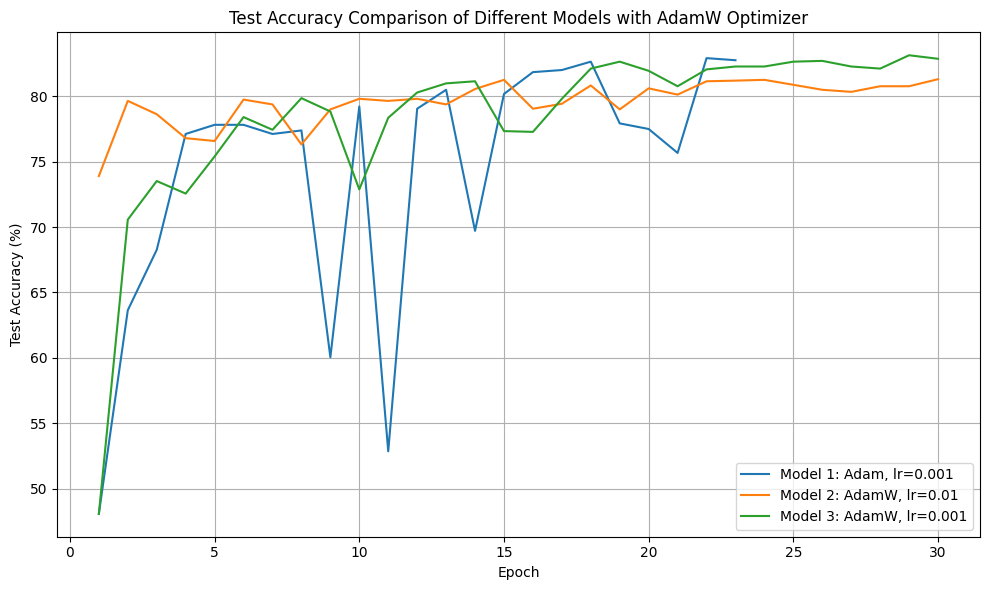

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO  # StringIO from the io module

# CSV Data
csv_data_1 = """
Epoch,Train Loss,Train Acc,Test Loss,Test Acc
1,0.6322,66.88,0.7715,48.07
2,0.5642,74.40,0.7279,63.64
3,0.5422,76.89,0.6280,68.26
4,0.5293,77.58,0.5303,77.12
5,0.5004,80.41,0.5417,77.82
6,0.5024,80.80,0.5237,77.82
7,0.4988,80.26,0.5250,77.12
8,0.4891,81.97,0.5185,77.39
9,0.4958,80.51,0.8341,60.04
10,0.4955,80.80,0.5031,79.22
11,0.4819,82.17,0.8913,52.85
12,0.4639,82.41,0.4876,79.05
13,0.4716,82.36,0.5028,80.50
14,0.4602,83.68,0.6860,69.71
15,0.4693,83.39,0.5101,80.18
16,0.4459,83.83,0.4679,81.85
17,0.4399,84.37,0.4834,82.01
18,0.4344,85.25,0.4543,82.65
19,0.4350,85.78,0.5445,77.93
20,0.4319,85.54,0.5464,77.50
21,0.4205,86.13,0.5533,75.67
22,0.4163,85.93,0.4576,82.92
23,0.4097,87.01,0.4766,82.76
"""

csv_data_2 = """
Epoch,Train Loss,Train Acc,Test Loss,Test Acc
1,0.5158,80.12,0.5910,73.90
2,0.4988,81.00,0.5050,79.65
3,0.5053,80.70,0.5119,78.63
4,0.4966,81.24,0.5166,76.80
5,0.4895,82.51,0.5622,76.58
6,0.4891,81.49,0.4945,79.75
7,0.4757,83.59,0.4944,79.38
8,0.4783,82.90,0.5425,76.32
9,0.4814,82.76,0.4982,79.00
10,0.4836,82.27,0.4871,79.81
11,0.4770,82.71,0.4881,79.65
12,0.4761,83.24,0.4941,79.81
13,0.4769,82.61,0.5039,79.38
14,0.4728,83.00,0.4829,80.56
15,0.4658,83.34,0.4853,81.26
16,0.4694,83.73,0.4892,79.05
17,0.4728,84.37,0.4879,79.43
18,0.4640,83.68,0.4810,80.83
19,0.4626,83.93,0.4964,79.00
20,0.4700,83.39,0.4830,80.61
21,0.4691,83.29,0.4830,80.13
22,0.4596,83.98,0.4790,81.15
23,0.4578,84.71,0.4774,81.20
24,0.4674,84.27,0.4788,81.26
25,0.4564,84.81,0.4784,80.88
26,0.4515,85.10,0.4807,80.50
27,0.4653,85.00,0.4810,80.34
28,0.4632,83.63,0.4801,80.77
29,0.4648,83.59,0.4798,80.77
30,0.4588,84.90,0.4785,81.31
"""

csv_data_3 = """
Epoch,Train Loss,Train Acc,Test Loss,Test Acc
1,0.6429,66.24,0.8967,48.07
2,0.5832,73.03,0.6240,70.57
3,0.5375,76.65,0.5986,73.52
4,0.5145,78.70,0.5702,72.56
5,0.5163,79.09,0.5331,75.40
6,0.5130,79.63,0.5039,78.41
7,0.4868,81.68,0.5129,77.44
8,0.4808,82.41,0.4908,79.86
9,0.4663,82.22,0.5181,78.84
10,0.4750,83.05,0.5907,72.88
11,0.4755,82.22,0.5147,78.36
12,0.4633,83.10,0.4813,80.29
13,0.4425,84.27,0.4744,80.99
14,0.4484,83.93,0.4660,81.15
15,0.4457,84.42,0.5452,77.34
16,0.4448,85.05,0.5259,77.28
17,0.4327,85.10,0.5259,79.81
18,0.4335,85.25,0.4660,82.12
19,0.4252,84.90,0.4574,82.65
20,0.4168,86.61,0.4741,81.95
21,0.4180,86.22,0.5048,80.77
22,0.4184,86.17,0.4685,82.06
23,0.4197,86.66,0.4633,82.28
24,0.4119,87.01,0.4545,82.28
25,0.4062,86.47,0.4540,82.65
26,0.4128,87.15,0.4571,82.71
27,0.4035,87.79,0.4741,82.28
28,0.4008,87.45,0.4617,82.12
29,0.4007,87.20,0.4489,83.14
30,0.3981,87.93,0.4584,82.87
"""

# Read CSV from string data
df1 = pd.read_csv(StringIO(csv_data_1))
df2 = pd.read_csv(StringIO(csv_data_2))
df3 = pd.read_csv(StringIO(csv_data_3))

# Plot Test Accuracy
plt.figure(figsize=(10, 6))

plt.plot(df1['Epoch'], df1['Test Acc'], label='Model 1: Adam, lr=0.001')
plt.plot(df2['Epoch'], df2['Test Acc'], label='Model 2: AdamW, lr=0.01')
plt.plot(df3['Epoch'], df3['Test Acc'], label='Model 3: AdamW, lr=0.001')

plt.title('Test Accuracy Comparison of Different Models with AdamW Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


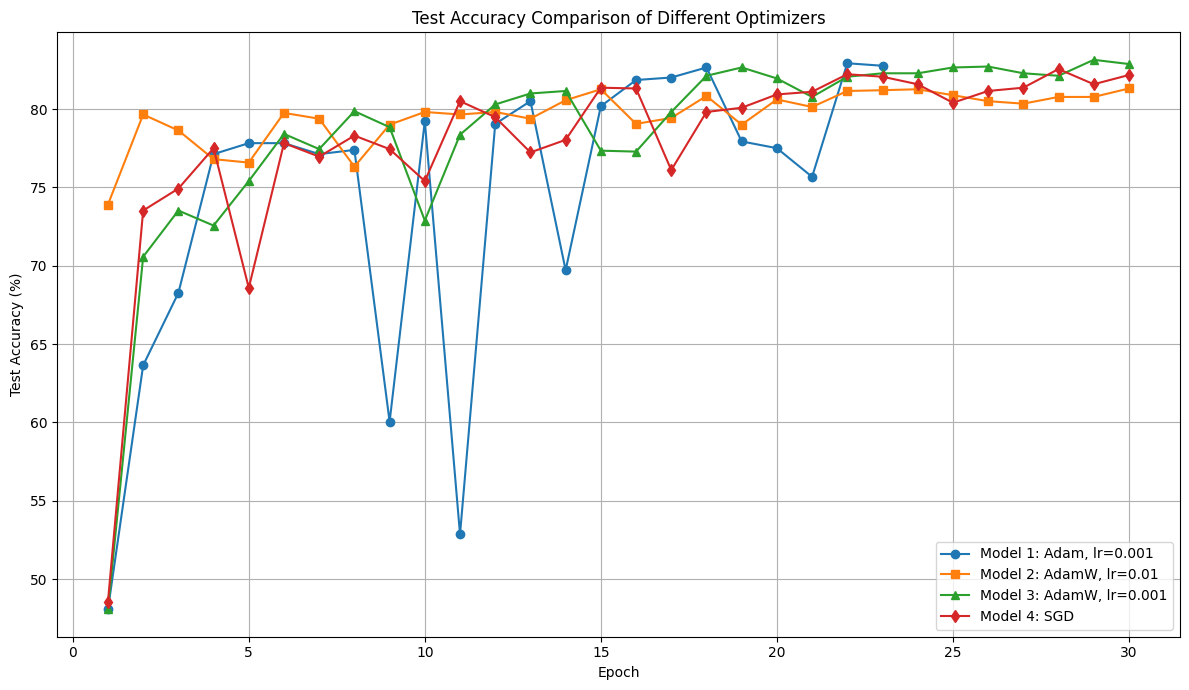

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# CSV Data for Adam
csv_data_1 = """
Epoch,Train Loss,Train Acc,Test Loss,Test Acc
1,0.6322,66.88,0.7715,48.07
2,0.5642,74.40,0.7279,63.64
3,0.5422,76.89,0.6280,68.26
4,0.5293,77.58,0.5303,77.12
5,0.5004,80.41,0.5417,77.82
6,0.5024,80.80,0.5237,77.82
7,0.4988,80.26,0.5250,77.12
8,0.4891,81.97,0.5185,77.39
9,0.4958,80.51,0.8341,60.04
10,0.4955,80.80,0.5031,79.22
11,0.4819,82.17,0.8913,52.85
12,0.4639,82.41,0.4876,79.05
13,0.4716,82.36,0.5028,80.50
14,0.4602,83.68,0.6860,69.71
15,0.4693,83.39,0.5101,80.18
16,0.4459,83.83,0.4679,81.85
17,0.4399,84.37,0.4834,82.01
18,0.4344,85.25,0.4543,82.65
19,0.4350,85.78,0.5445,77.93
20,0.4319,85.54,0.5464,77.50
21,0.4205,86.13,0.5533,75.67
22,0.4163,85.93,0.4576,82.92
23,0.4097,87.01,0.4766,82.76
"""

# CSV Data for AdamW lr=0.01
csv_data_2 = """
Epoch,Train Loss,Train Acc,Test Loss,Test Acc
1,0.5158,80.12,0.5910,73.90
2,0.4988,81.00,0.5050,79.65
3,0.5053,80.70,0.5119,78.63
4,0.4966,81.24,0.5166,76.80
5,0.4895,82.51,0.5622,76.58
6,0.4891,81.49,0.4945,79.75
7,0.4757,83.59,0.4944,79.38
8,0.4783,82.90,0.5425,76.32
9,0.4814,82.76,0.4982,79.00
10,0.4836,82.27,0.4871,79.81
11,0.4770,82.71,0.4881,79.65
12,0.4761,83.24,0.4941,79.81
13,0.4769,82.61,0.5039,79.38
14,0.4728,83.00,0.4829,80.56
15,0.4658,83.34,0.4853,81.26
16,0.4694,83.73,0.4892,79.05
17,0.4728,84.37,0.4879,79.43
18,0.4640,83.68,0.4810,80.83
19,0.4626,83.93,0.4964,79.00
20,0.4700,83.39,0.4830,80.61
21,0.4691,83.29,0.4830,80.13
22,0.4596,83.98,0.4790,81.15
23,0.4578,84.71,0.4774,81.20
24,0.4674,84.27,0.4788,81.26
25,0.4564,84.81,0.4784,80.88
26,0.4515,85.10,0.4807,80.50
27,0.4653,85.00,0.4810,80.34
28,0.4632,83.63,0.4801,80.77
29,0.4648,83.59,0.4798,80.77
30,0.4588,84.90,0.4785,81.31
"""

# CSV Data for AdamW lr=0.001
csv_data_3 = """
Epoch,Train Loss,Train Acc,Test Loss,Test Acc
1,0.6429,66.24,0.8967,48.07
2,0.5832,73.03,0.6240,70.57
3,0.5375,76.65,0.5986,73.52
4,0.5145,78.70,0.5702,72.56
5,0.5163,79.09,0.5331,75.40
6,0.5130,79.63,0.5039,78.41
7,0.4868,81.68,0.5129,77.44
8,0.4808,82.41,0.4908,79.86
9,0.4663,82.22,0.5181,78.84
10,0.4750,83.05,0.5907,72.88
11,0.4755,82.22,0.5147,78.36
12,0.4633,83.10,0.4813,80.29
13,0.4425,84.27,0.4744,80.99
14,0.4484,83.93,0.4660,81.15
15,0.4457,84.42,0.5452,77.34
16,0.4448,85.05,0.5259,77.28
17,0.4327,85.10,0.5259,79.81
18,0.4335,85.25,0.4660,82.12
19,0.4252,84.90,0.4574,82.65
20,0.4168,86.61,0.4741,81.95
21,0.4180,86.22,0.5048,80.77
22,0.4184,86.17,0.4685,82.06
23,0.4197,86.66,0.4633,82.28
24,0.4119,87.01,0.4545,82.28
25,0.4062,86.47,0.4540,82.65
26,0.4128,87.15,0.4571,82.71
27,0.4035,87.79,0.4741,82.28
28,0.4008,87.45,0.4617,82.12
29,0.4007,87.20,0.4489,83.14
30,0.3981,87.93,0.4584,82.87
"""

# CSV Data for SGD
csv_data_sgd = """
Epoch,Train Loss,Train Acc,Test Loss,Test Acc
1,0.6489,64.09,0.7197,48.55
2,0.5903,72.25,0.5703,73.52
3,0.5630,74.60,0.5595,74.92
4,0.5414,76.45,0.5254,77.50
5,0.5097,78.65,0.6525,68.58
6,0.5066,79.87,0.5186,77.82
7,0.4988,79.87,0.5359,76.96
8,0.5035,79.09,0.5091,78.30
9,0.4863,81.29,0.5123,77.44
10,0.4865,80.61,0.5635,75.40
11,0.4747,81.83,0.4908,80.50
12,0.4675,82.61,0.4999,79.48
13,0.4781,81.97,0.5382,77.23
14,0.4753,81.44,0.5300,78.03
15,0.4592,82.80,0.4730,81.36
16,0.4511,83.98,0.4773,81.31
17,0.4514,83.73,0.5833,76.10
18,0.4507,84.17,0.5005,79.81
19,0.4387,85.25,0.4869,80.08
20,0.4391,85.30,0.4726,80.93
21,0.4400,85.00,0.4832,81.10
22,0.4362,84.95,0.4706,82.22
23,0.4455,83.83,0.4747,82.06
24,0.4329,85.64,0.4662,81.58
25,0.4353,84.86,0.5007,80.40
26,0.4336,85.78,0.4790,81.15
27,0.4338,85.54,0.4724,81.36
28,0.4207,85.88,0.4616,82.55
29,0.4245,85.25,0.4622,81.58
30,0.4285,85.93,0.4626,82.17
"""

# Read CSV from string data into DataFrames
df1 = pd.read_csv(StringIO(csv_data_1))
df2 = pd.read_csv(StringIO(csv_data_2))
df3 = pd.read_csv(StringIO(csv_data_3))
df_sgd = pd.read_csv(StringIO(csv_data_sgd))

# Plot Test Accuracy comparison
plt.figure(figsize=(12, 7))

plt.plot(df1['Epoch'], df1['Test Acc'], marker='o', label='Model 1: Adam, lr=0.001')
plt.plot(df2['Epoch'], df2['Test Acc'], marker='s', label='Model 2: AdamW, lr=0.01')
plt.plot(df3['Epoch'], df3['Test Acc'], marker='^', label='Model 3: AdamW, lr=0.001')
plt.plot(df_sgd['Epoch'], df_sgd['Test Acc'], marker='d', label='Model 4: SGD')

plt.title('Test Accuracy Comparison of Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
